In [28]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
def plot_background_fct(send_data, recv_data, label, do_plot=True):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Background FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [30]:
def plot_foreground_fct(send_data, recv_data, label, do_plot=True):
    # diffs in micrseconds
    diffs = (recv_data - send_data) * 1000 * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Foreground FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Microseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [31]:
def plot_fanout(send_data, recv_data, label, do_plot=True, res_type="max"):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if res_type=="max":
        diffs = np.max(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="avg":
        diffs = np.mean(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="min":
        diffs = np.min(diffs[:,:diffs.shape[1]-1],1)
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="RCT"+label) 
        ax1.set_title("Partition/Aggregate query completion time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Query ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [32]:
def servers_within_deadline(send_data, recv_data, deadline = 20):
    # diffs and deadline in miliseconds
    diffs = (recv_data - send_data) * 1000.0
    diffs_within_deadline = diffs < deadline
    num_serv_that_meet_deadline = np.sum(diffs_within_deadline,1)
    print(num_serv_that_meet_deadline.shape)
    num_serv_that_meet_deadline = np.sort(num_serv_that_meet_deadline, axis=0)
    end = int(np.round(0.01*num_serv_that_meet_deadline.shape[0]))
    print(end)
    res_99 = np.mean(num_serv_that_meet_deadline[:end])
    print(num_serv_that_meet_deadline[:end])
    return np.mean(num_serv_that_meet_deadline), res_99

In [33]:
def plot_queue_size(data, label, do_plot=True):
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [34]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    results in microseconds
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing microseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [35]:
def print_results(fore=True, back=True, fanout_max=True, fanout_avg=True, fanout_min=True):
    print("Mean Q length in Kbytes {0} and in packets {1}\n99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}\n".format(delay_mean, delay_99))
    if fore:
        print("Foreground FCT (us): mean: {0}, 99th %: {1}\n".format(frg_mean, frg_99))
    if back:
        print("Background FCT (ms): mean: {0}, 99th %: {1}\n".format(bkg_mean, bkg_99))
    if fanout_max:
        print("Fanout max QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_max_mean, fan_max_99))
    if fanout_avg:
        print("Fanout avg QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_avg_mean, fan_avg_99))
    if fanout_min:
        print("Fanout min QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_min_mean, fan_min_99))
        print("Servers in deadline: mean: {0}, 99th %: {1}\n".format(servers_mean, servers_99))
        
    
    
    #print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

## Just fanout, workload 1 at 30% - 10 flows

In [36]:
results_folders = ["/TCP/", "/DCTCP30/", "/DCTCP_pacer_PQ/"]
latency = dict()
bkg_fct = dict()
frg_fct = dict()
fanout_qct_max = dict()
fanout_qct_avg = dict()
fanout_qct_min = dict()
servers_in_deadline = dict()

deadline = 25


for folder in results_folders:
    latency[folder] = []
    bkg_fct[folder] = []
    frg_fct[folder] = []
    fanout_qct_max[folder] = []
    fanout_qct_avg[folder] = []
    fanout_qct_min[folder] = []    
    servers_in_deadline[folder] = []        

In [37]:
simul_folder = "onlyfanout_wkld1_30_10flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=False, fanout_max=True, fanout_avg=True, fanout_min=True)
    
    """
    (0,1484)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,0)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1281)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,0)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(17902,)
179
[7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
/TCP/
Mean Q length in Kbytes 0.0015355821184659074 and in packets 0.002769084450963737
99th percentile in Kbytes 0.012299856501295078 and in packets 0.018469970278072623

Mean delay in us 0.01228465694772726 and 99th percentile delay in us 0.09839885201036062

Fanout max QCT (ms): mean: 11.897770383905286, 99th %: 30.784710714558422

Fanout avg QCT (ms): mean: 4.146158019361562, 99th %: 10.421397831152552

Fanout min QCT (ms): mean: 0.631471528228694, 99th %: 2.7600654521360535

Servers in deadline: mean: 9.96598145458608, 99th %: 8.782122905027933

(17902,)
179
[7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

## Fanout, workload 1 at 30% + background traffic at 200Mbps - 10 flows 

In [38]:
simul_folder = "bkg200_fanout_wkld1_30_10flows"

for folder in results_folders:
    print(folder)
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,1695)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,12071)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1396)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,40)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    
    (0,5135)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,35896)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,4273)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,143)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/TCP/


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(17902,)
179
[5 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
Mean Q length in Kbytes 24.368749011000634 and in packets 25.50910068492422
99th percentile in Kbytes 270.1859479828205 and in packets 281.6441724982884

Mean delay in us 194.94999208800508 and 99th percentile delay in us 2161.487583862564

Background FCT (ms): mean: 103.52956298308366, 99th %: 245.01769062216965

Fanout max QCT (ms): mean: 12.546527680541285, 99th %: 31.75859349421643

Fanout avg QCT (ms): mean: 4.760411260166062, 99th %: 12.408711770412577

Fanout min QCT (ms): mean: 1.1892697972083772, 99th %: 7.046610470279454

Servers in deadline: mean: 9.954418500726176, 99th %: 8.541899441340782

/DCTCP30/
(1

## Fanout, workload 1 at 30% + background traffic at 400Mbps - 10 flows 

In [39]:
simul_folder = "bkg400_fanout_wkld1_30_10flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,2128)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,41889)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1680)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,86)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(17902,)
179
[6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
/TCP/
Mean Q length in Kbytes 59.96069446711135 and in packets 62.64765287492696
99th percentile in Kbytes 363.78606950768824 and in packets 381.04814717702595

Mean delay in us 479.6855557368908 and 99th percentile delay in us 2910.288556061506

Background FCT (ms): mean: 131.64151039590408, 99th %: 345.1595108309764

Fanout max QCT (ms): mean: 13.482157273110968, 99th %: 34.50743298026969

Fanout avg QCT (ms): mean: 5.5778214090820475, 99th %: 14.77229681987614

Fanout min QCT (ms): mean: 1.9295389044710491, 99th %: 9.07806752987011

Servers in deadline: mean: 9.935258630320634, 99th %: 8.11731843575419

(17902,)


## Fanout, workload 1 at 30% + background traffic at 600Mbps - 10 flows 

In [40]:
simul_folder = "bkg600_fanout_wkld1_30_10flows"

for folder in results_folders:
    print(folder)
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    print(bkg_send.shape, bkg_recv.shape)
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,2553)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,90697)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1870)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,94)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/TCP/
(1164,) (1164,)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(17902,)
179
[0 1 1 1 2 2 3 3 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
Mean Q length in Kbytes 120.57980801071712 and in packets 126.11285920830504
99th percentile in Kbytes 433.0352238059614 and in packets 453.6144354808317

Mean delay in us 964.6384640857369 and 99th percentile delay in us 3464.281790447691

Background FCT (ms): mean: 221.04943026647524, 99th %: 1001.7176600691549

Fanout max QCT (ms): mean: 15.976464989308655, 99th %: 69.21631593915572

Fanout avg QCT (ms): mean: 7.340033034751902, 99th %: 21.66394650635197

Fanout min QCT (ms): mean: 3.427854114742588, 99th %: 11.927080711995188

Servers in deadline: mean: 9.860183219751983, 99th %: 6.435754189944134

/DCTCP30/
(11

In [41]:
print("--------latency----------")
print(latency)
print("--------bkg----------")
print(bkg_fct)
print("--------fan_max----------")
print(fanout_qct_max)
print("--------fan_avg---------")
print(fanout_qct_avg)
print("--------fan_min---------")
print(fanout_qct_min)
print("--------quality---------")
print(servers_in_deadline)


--------latency----------
{'/TCP/': [(0.01228465694772726, 0.09839885201036062), (194.94999208800508, 2161.487583862564), (479.6855557368908, 2910.288556061506), (964.6384640857369, 3464.281790447691)], '/DCTCP30/': [(0.01228465694772726, 0.09839885201036062), (49.513099571933694, 290.8379433714561), (100.0287237277226, 306.14595949470544), (154.77828892709445, 294.5190185111108)], '/DCTCP_pacer_PQ/': [(0.011414155440468844, 0.08076021362472902), (0.4190400566531573, 6.043641347270268), (3.094886951828673, 43.63513143228522), (17.680339628567985, 124.96168105734203)]}
--------bkg----------
{'/TCP/': [(103.52956298308366, 245.01769062216965), (131.64151039590408, 345.1595108309764), (221.04943026647524, 1001.7176600691549)], '/DCTCP30/': [(106.35021437722611, 248.5528733098147), (140.31445277024554, 358.3971579138884), (243.82612005683583, 1023.8290865498302)], '/DCTCP_pacer_PQ/': [(232.65285265332508, 330.02715494803925), (283.55254040524807, 479.4969638797777), (393.38224706997136, 11

/home/konspras/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


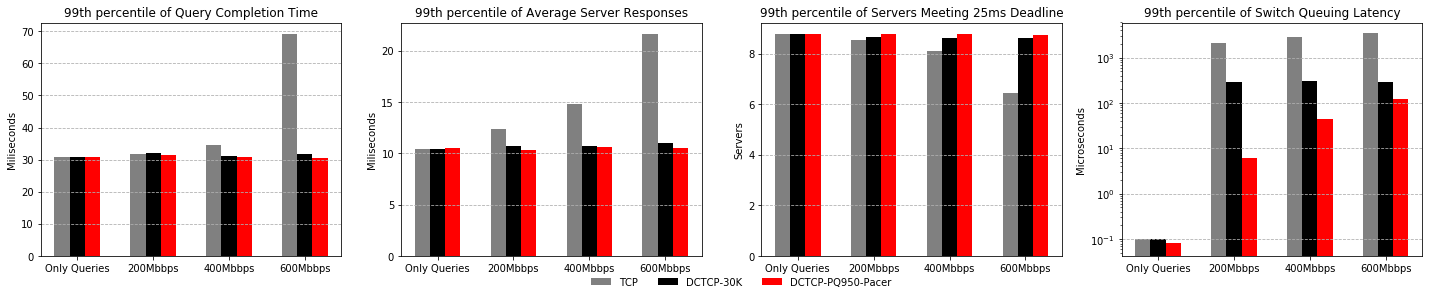

In [42]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
config_num = 4
ind = np.arange(config_num)
width = 0.2
x_axis_labels = ('Only Queries', '200Mbbps', '400Mbbps', '600Mbbps')
# qct max
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_max[folder]])
p1 = ax1.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax1.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax1.bar(ind+1.5*width, res[2], width, color='r')


ax1.set_title('99th percentile of Query Completion Time')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(x_axis_labels)
# ax1.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='upper left')
ax1.set_ylabel('Miliseconds')
ax1.yaxis.grid(linestyle="--")


# qct avg
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_avg[folder]])
p1 = ax2.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax2.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax2.bar(ind+1.5*width, res[2], width, color='r')


ax2.set_title('99th percentile of Average Server Responses')
ax2.set_xticks(ind + width / 2)
ax2.set_xticklabels(x_axis_labels)
# ax2.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='upper left')
ax2.set_ylabel('Miliseconds')
ax2.yaxis.grid(linestyle="--")


# Quality
res = []
for folder in results_folders:
    res.append([x[1] for x in servers_in_deadline[folder]])
p1 = ax3.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax3.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax3.bar(ind+1.5*width, res[2], width, color='r')


ax3.set_title('99th percentile of Servers Meeting 25ms Deadline')
ax3.set_xticks(ind + width / 2)
ax3.set_xticklabels(x_axis_labels)
# ax3.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='lower left')
ax3.set_ylabel('Servers')
ax3.yaxis.grid(linestyle="--")



# Switch Latency
res = []
for folder in results_folders:
    res.append([x[1] for x in latency[folder]])
p1 = ax4.bar(ind-0.5*width, res[0], width, color='grey',log=True)
p2 = ax4.bar(ind+0.5*width, res[1], width, color='k',log=True)
p3 = ax4.bar(ind+1.5*width, res[2], width, color='r',log=True)


ax4.set_title('99th percentile of Switch Queuing Latency')
ax4.set_xticks(ind + width / 2)
ax4.set_xticklabels(x_axis_labels)
# ax4.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='lower right')
ax4.set_ylabel('Microseconds')
ax4.yaxis.grid(linestyle="--")

fig.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.41,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()

In [43]:
# fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,10))
# for i, setup in enumerate(results_folders):
#     ax1.bar(i-0.4, latency[setup][0][0], width=0.1, log=True, color="blue")
#     ax1.bar(i-0.3, latency[setup][0][1], width=0.1, log=True, color="blue")
#     ax1.bar(i-0.1, latency[setup][1][0], width=0.1, log=True, color="red")
#     ax1.bar(i, latency[setup][1][1], width=0.1, log=True, color="red")
#     ax1.bar(i+0.2, latency[setup][2][0], width=0.1, log=True, color="green")
#     ax1.bar(i+0.3, latency[setup][2][1], width=0.1, log=True, color="green")
# ax1.set_title("Switch Latency")
# ax1.legend(loc='upper left')
# ax1.set_ylabel('Queuing miliseconds')
# ax1.set_xlabel('Scheme')
# ax1.grid(which='major', linestyle="-")
# #ax1.grid(which='minor', linestyle='--')

# fig.tight_layout()   

# fig.savefig("Queuing delay vs Time.png", format="png")
# fig.show()